In [78]:
%reset -f
%load_ext autoreload
%autoreload 2

import sys
import os

sys.path.append(os.path.join(os.path.pardir, 'code'))
figdir = os.path.join(os.path.pardir, 'figures')
savedir = os.path.join(os.path.pardir, 'simulation_data')

import numpy as np
import numpy.matlib
import scipy
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap
import itertools
import control
import pickle
import figurefirst as fifi

import figure_functions as ff
from fly_wind_simple import FlyWindSimpleCal
from simulator import LinearSystemSimulator
from observability import ObservabilityMatrix
from eiso import optimize_matrix_rows_to_state, optimize_matrix_rows_to_states, optimize_matrix_rows_to_states_iterative
from eiso import analytical_observability_gramian, calculate_condition_number, rank_test

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Define system simulator object

In [79]:
sys = FlyWindSimpleCal()

### Set simulation settings

In [80]:
saveflag = True
control_type = 'phi_v' # 'none', 'phi', 'v', or 'phi_v'

alpha = 1e-6
beta = 1e-3
sigma = 1e-8
norm = None
square=False

# sys.set_output_mode(['phi', 'gamma'], angular_outputs=[0, 1])
sys.set_output_mode(['phi', 'gamma', 'of'], angular_outputs=[0, 1])

### Simulate

In [81]:
# Set time & input(s)
T = 5 # total time [s]
fs = 10 # sampling rate [hz]
ts = 1 / fs # time step [s]

# Simulation time
tsim = np.arange(0, T + ts, ts).T
n_point = tsim.shape[0]
tindex = np.arange(1, n_point + 1, 1)

# Simulation input
usim = 0 * np.ones((len(tsim), 2))
if control_type == 'v':
    v0 = 11
    phi0 = np.pi/4
    usim[3*fs:4*fs, 0] = 7
    
elif control_type == 'phi':
    v0 = 11
    phi0 = np.pi/4
    usim[1*fs:2*fs, 1] = np.pi/2
    usim[3*fs:4*fs, 1] = -np.pi/2
    
elif control_type == 'phi_v':
    v0 = 11
    phi0 = (np.pi/2) + np.pi/4
    usim[2*fs:3*fs, 1] = -np.pi/2
    usim[4*fs:5*fs, 0] = 10
    
elif control_type == 'none':
    phi0 = np.pi/4
    v0 = 11

# Initial conditions
d0 = 2
w0 = 7
zeta0 = 0

x0 = np.array([d0, v0, w0, phi0, zeta0])
print(x0)

# Simulate
sim_data, _ = sys.simulate(x0, tsim, usim)

# Get sizes
n_state = sys.n
n_output = sys.p

[ 2.         11.          7.          2.35619449  0.        ]


### Plot trajectory

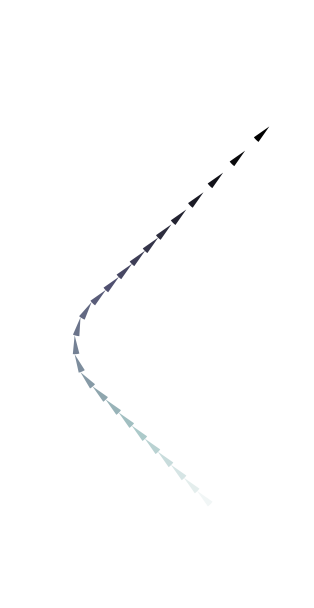

In [82]:
fig, ax = plt.subplots(1, 1, figsize=(7*1, 7*1), dpi=100)
cmap = 'bone_r'

xpos = sim_data['pos_x']
ypos = sim_data['pos_y']
phi = sim_data['phi']

size_radius = 3*0.05*np.mean(np.abs(np.hstack((xpos, ypos))))
ff.plot_trajectory(xpos,
                   ypos,
                   phi,
                   color=tsim,
                   ax=ax,
                   nskip=1,
                   size_radius=size_radius,
                   colormap=cmap)

fifi.mpl_functions.adjust_spines(ax, [])

### Evaluate observability in sliding windows

In [83]:
# Set system & the nominal state trajectory to calculate empirical Observability Matrix (Oe)
Obsv = ObservabilityMatrix(sys, sim_data['time'], sim_data['x'], sim_data['u'])

time_resolution = 0.1 # sliding the window resolution
simulation_time = 0.3 # simulation time to compute empirical O at each point
Oe_sliding, O_time, deltay_all = Obsv.sliding_O(time_resolution=time_resolution,
                                                simulation_time=simulation_time,
                                                eps=0.001)
n_window = len(Oe_sliding)
print(str(n_window) + ' windows')

48 windows


### Run E-ISO for each sliding window

In [84]:
observability_error_over_time = np.nan * np.zeros((n_window, n_state))
CN_iter_over_time = np.nan * np.zeros((n_window, n_state))

states_of_interest = np.arange(0, n_state, 1)
for w in range(n_window):
    print(w, end=', ')
    for s in states_of_interest:       
        out = optimize_matrix_rows_to_state(Oe_sliding[w],
                                            state=s,
                                            alpha=alpha,
                                            beta=beta,
                                            square=square,
                                            sigma=sigma,
                                            include_constraints=False,
                                            norm=norm)
        
        observability_error_over_time[w, s] = out['En']
        
        out = optimize_matrix_rows_to_states_iterative(Oe_sliding[w],
                                                       states=[s],
                                                       alpha=alpha,
                                                       beta=beta,
                                                       sigma=sigma,
                                                       square=square,
                                                       include_constraints=False,
                                                       norm=norm)
        
        CN_iter_over_time[w, s] = out['CN_min']
            
print('Done')

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, Done


In [85]:
O_index = O_time * np.array(fs)
O_value = np.zeros_like(CN_iter_over_time)
for w in range(n_window):
    for s in range(n_state):
        O_value[w, s] = sim_data['x'][int(O_index[w]), s]

### Plot trajectory for each state, where color indicates observability

In [86]:
# State labels
sys.state_names
state_labels = [r'$d$', r'$g$', r'$w$', r'$\phi$', r'$\zeta$']

In [87]:
# Colormap
crange = 0.8
cmap = cm.get_cmap('RdPu_r')
cmap = cmap(np.linspace(0, crange, 100))
cmap = ListedColormap(cmap)

cmapr = cm.get_cmap('RdPu')
cmapr = cmapr(np.linspace(1-crange, 1, 100))
cmapr = ListedColormap(cmapr)

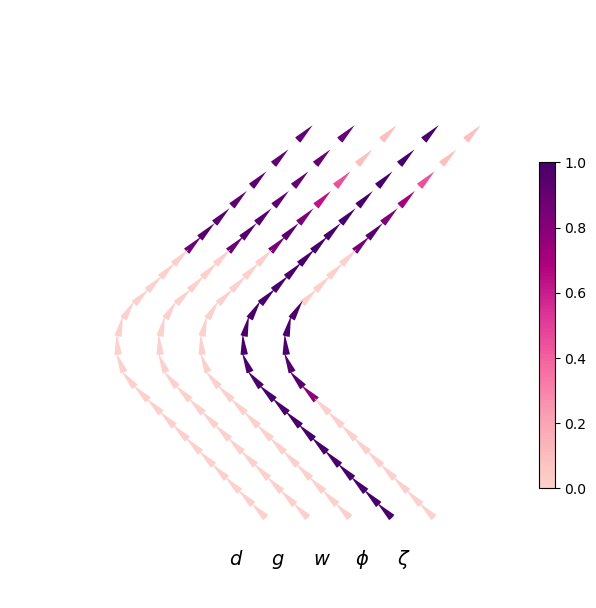

In [88]:
fig, ax = plt.subplots(1, 1, figsize=(7*1, 7*1), dpi=100)

xpos = sim_data['pos_x']
ypos = sim_data['pos_y']
theta = sim_data['phi']

xoff = 5
yoff = 0

cvar = CN_iter_over_time.copy()
cvar = np.nan_to_num(cvar, nan=1.1*np.nanmax(cvar))
cnorm = (np.min(cvar), np.max(cvar))
for n in range(n_state):
    cvar_state = scipy.interpolate.griddata(O_time, cvar[:,n], sim_data['time'], method='nearest')
    
    arrow_size_res = 1
    size_radius = arrow_size_res*0.17*np.mean(np.abs(np.hstack((xpos, ypos))))
    xinit = xpos + xoff*n
    yinit = ypos + yoff*n
    ff.plot_trajectory(xinit,
                       yinit,
                       theta,
                       color=cvar_state,
                       ax=ax,
                       size_radius=size_radius,
                       nskip=1,
                       colormap=cmap,
                       colornorm=cnorm)
    
    ax.text(xinit[0] - 4, yinit[0] - 6, state_labels[n], fontsize=14)

ax.set_xlim((np.min(xpos - xoff), np.max(xpos + xoff*n_state)))
# ax.set_ylim((np.min(ypos - yoff), 1.1*np.max(ypos + yoff*n_state)))

fig.colorbar(cm.ScalarMappable(cmap=cmapr), ax=ax, fraction=0.03)

fifi.mpl_functions.adjust_spines(ax, [])

### Save data

In [89]:
if saveflag:
    if control_type=='v':
        savename = 'control_v_output'
    elif control_type=='phi':
        savename = 'control_phi_output'
    elif control_type=='phi_v':
        savename = 'control_phi_v_output'
    elif control_type=='none':
        savename = 'control_none_output'
        
    savename = savename + '_' + '_'.join(sys.output_names) + '.pk'
    
    savepath = os.path.join(savedir, savename)

    savedata = {'sim_data': sim_data,
                'alpha': alpha,
                'beta': beta,
                'norm': norm,
                'sliding_simulation_time': simulation_time,
                'Oe_sliding': Oe_sliding,
                'Oe_sliding_index': O_index,
                'Oe_sliding_time': O_time,
                'Oe_sliding_value': O_value,
                'CN_iter_over_time': CN_iter_over_time,
                'observability_error_over_time': observability_error_over_time}

    with open(savepath, 'wb') as fp:
        pickle.dump(savedata, fp)

    with open(savepath, 'rb') as fp:
        data = pickle.load(fp)

    print(data.keys())

dict_keys(['sim_data', 'alpha', 'beta', 'norm', 'sliding_simulation_time', 'Oe_sliding', 'Oe_sliding_index', 'Oe_sliding_time', 'Oe_sliding_value', 'CN_iter_over_time', 'observability_error_over_time'])
